In [ ]:
!conda install -c conda-forge fbprophet -y

/bin/bash: conda: command not found


In [ ]:
!pip install --upgrade plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

##########################
# Configuración Matplotlib

plt.style.use('seaborn')
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['xtick.minor.bottom'] = False
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# Diccionario de colores que usaremos más adelante 
dayofweek_colors = {0: 'tab:blue',
                    1: 'tab:orange',
                    2: 'tab:green', 3: 'tab:red', 
                    4: 'tab:purple', 5: 'tab:brown', 
                    6: 'tab:pink'}


In [ ]:
#df = pd.read_excel(r"C:\Users\Nach\Desktop\TFM\datos\datos_limpios\dataset_ventas.xlsx")
df = pd.read_excel("/content/dataset_ventas.xlsx")


In [ ]:
#Convertimos los valores meteorológicos a formato float previamente sustituyendo las comas por puntos
df['prec'] = [x.replace(',','.').replace('Ip', '0') for x in df['prec']]
df['tmax'] = [x.replace(',','.') for x in df['tmax']]

In [ ]:
df = df.astype({'fecha': 'datetime64[ns]','mes': 'int', 'dia': 'int', 'dia_semana': 'int','prec': 'float', 'tmax': 'float',  'ventas': 'float'}, copy=False)

In [ ]:
df.head()

fecha  festivo  mes  dia  dia_semana  prec  tmax  ventas
0 2021-09-04        0    9    4           5   0.0  30.6   247.0
1 2021-09-05        0    9    5           6   0.0  32.7   172.0
2 2021-09-08        0    9    8           2   0.0  28.0    20.0
3 2021-09-09        0    9    9           3   0.0  27.1     5.0
4 2021-09-10        0    9   10           4   0.0  28.2    76.0

In [ ]:
# La variable fecha es interesante que sea de tipo Datetime
df.dtypes

fecha         datetime64[ns]
festivo                int64
mes                    int64
dia                    int64
dia_semana             int64
prec                 float64
tmax                 float64
ventas               float64
dtype: object

In [ ]:
df.describe()

festivo         mes         dia  dia_semana        prec        tmax  \
count  357.000000  357.000000  357.000000  357.000000  357.000000  357.000000   
mean     0.025210    7.582633   15.434174    3.613445    1.085994   22.471429   
std      0.156983    3.380717    8.911504    1.751929    4.100634    8.883916   
min      0.000000    1.000000    1.000000    0.000000    0.000000    7.600000   
25%      0.000000    5.000000    8.000000    2.000000    0.000000   14.300000   
50%      0.000000    9.000000   15.000000    4.000000    0.000000   21.900000   
75%      0.000000   10.000000   23.000000    5.000000    0.000000   29.200000   
max      1.000000   12.000000   31.000000    6.000000   48.300000   42.200000   

            ventas  
count   357.000000  
mean    293.839496  
std     381.268502  
min       1.650000  
25%      23.000000  
50%     127.400000  
75%     418.250000  
max    2103.250000

In [ ]:
#Reombramos las variables fecha y ventas(nuestra variable objetivo) por ds e y respectivamente ya que
#son estos los nombres que utilizaría el método Prophet para saber cuál es la columna temporal y cuál la que contiene la variable objetivo
df.rename(columns={'fecha':'ds', 'ventas':'y'}, inplace=True)

In [ ]:
#Comprobamos que no haya variables con valores nulos en el dataframe
df[df.isnull()].count()

ds            0
festivo       0
mes           0
dia           0
dia_semana    0
prec          0
tmax          0
y             0
dtype: int64

In [ ]:
#Comprobamos que no hay fechas duplicadas
df[df.ds.duplicated()]['ds'].count()

1

In [ ]:
#Exploración de los datos para buscar estacionalidades

In [ ]:
print('Fecha inicio del histórico: ', df.ds.min())
print('Fecha fin del histórico: ', df.ds.max())
print('Número total de días: ', df.ds.nunique())


Fecha inicio del histórico:  2021-09-04 00:00:00
Fecha fin del histórico:  2022-12-23 00:00:00
Número total de días:  356


In [ ]:
# Contamos el número de muestras por día de la semana. 0 = Lunes, 6 = Domingo
df.groupby(df.ds.dt.dayofweek).count()[['y']].rename(columns={'y': 'count'})

count
ds       
0       6
1      51
2      53
3      51
4      66
5      64
6      66

Observamos que las ventas se producen de martes a domingo (días 1 a 6).
Y que los lunes apenas hay muestras. De 356 días, solo 5 son lunes.
Vemos también que los días con más ventas son viernes, sábado y domingo

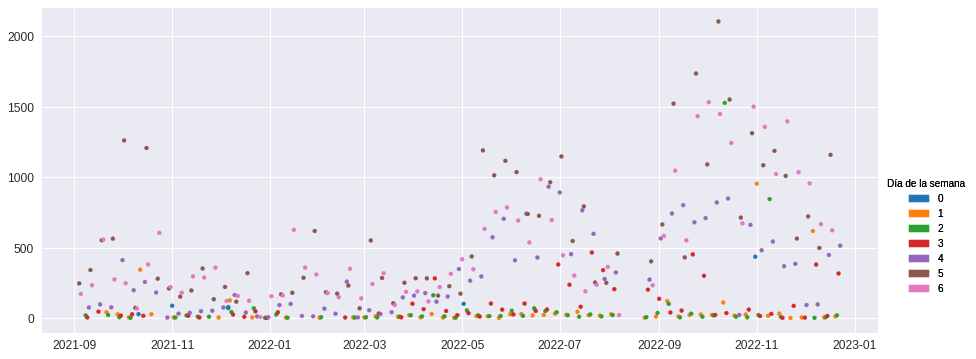

In [ ]:
# Gráfica que muestra el histórico por días de la semana

plt.close()
fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(df['ds'], df['y'], c=df['ds'].dt.dayofweek.map(dayofweek_colors))
handles = [mpatches.Patch(color=v, label=k) for v, k in zip(dayofweek_colors.values(), dayofweek_colors.keys())]
legend = ax.legend(handles=handles, bbox_to_anchor=(1, 0.5),
                   title="Día de la semana")
ax.add_artist(legend)
plt.show()


Esta gráfica nos aporta bastante información sobre la estacionalidad semanal.
Vemos como los días de martes a jueves muestran rangos de valores similares
en la mayoría de los casos mientras que los fines de semana  (viernes, sábado y domingo) las ventas son mayores.

Observamos como a partir de mayo de 2022 empiezan a aumentar los valores de ventas los fines de semana, aumentando la dispersión de los datos respecto al resto de días, lo que indica una clara estacionalidad para los fines de semana a partir de esa fecha. Podríamos decir que es debido al aumento de temperaturas, pero estos rangos se mantienen e incluso crecen hasta finales de diciembre 2022

También se observa como los valores van en aumento a lo largo del tiempo,
manteniéndose la estacionalidad global de los fines de semana.

In [ ]:
# Los lunes
df[df.ds.dt.dayofweek==0]


ds  festivo  mes  dia  dia_semana  prec  tmax       y
28  2021-10-11        0   10   11           0   0.0  23.4   29.00
41  2021-11-01        1   11    1           0   0.0  17.6   88.40
65  2021-12-06        0   12    6           0   0.0  14.4   72.00
66  2021-12-06        1   12    6           0   0.0  14.4   79.00
169 2022-05-02        0    5    2           0   0.8  18.3  101.70
312 2022-10-31        0   10   31           0   1.8  16.0  435.35

Vemos que los lunes son días en los que se producen pocas ventas por lo general
Esto principalmente se debe a que es un día de descanso en el que el restaurante abre pocas veces. Como única excepción vemos el día de Halloween en el que hubo más facturación de lo normal.
Por ello podemos descartar este día como un outlier y no hacer predicciones para este día, ya que es el día de libranza en el restaurante por lo general.
Aunque a futuro debería tenerse en cuenta por si hubiese días importantes cerca de un lunes.

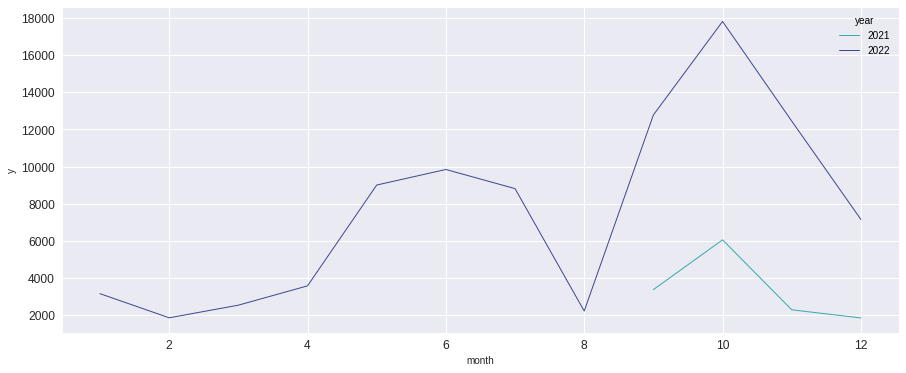

In [ ]:
#Análsis datos mensuales

por_años = df[['ds', 'y']].copy()
por_años['year'] = por_años.ds.dt.year
por_años['month'] = por_años.ds.dt.month
por_años = por_años.groupby(['year', 'month']).sum().reset_index()

plt.close()
palette = sns.color_palette("mako_r", 2)
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.lineplot(por_años['month'], por_años['y'], hue=por_años['year'], ax=ax, palette=palette)
plt.show()


En la gráfica anterior vemos cierto patrón anual, podemos observar como desde enero hasta abril, las ventas están contenidas, siendo a partir del mes de marzo cuando las ventas comienzan a subir hasta que llega el verano (julio-agosto), produciéndose nuevamente una gran subida en septiembre, hasta llegar otra vez a las vacaciones de navidad y el invierno de nuevo donde las ventas vuelven a bajar. Esto tiene bastante sentido ya que es un restaurante cuyas mesas se encuentran en una terraza cubierta por lo que los meses frío las ventas se ven resentidas y en los meses con buena temperatura las ventas suban, siendo octubre el mes con mayor número de ventas.
Además se puede apreciar como en periodos  vacacionales, los clientes no frecuentan tanto el centro deportivo y por lo tanto se ve reflejado en las ventas.

Pese a tener poca información histórica, vemos como respecto a los meses del año anterior,  ha habido un aumento en las ventas, observando indicios de una posible tendencia creciente de año en año, aunque esto se podrá apreciar según se vayan recopilando mayor número de datos históricos. 

Este aumentos en las ventas también puede deberse a que el 2021 es el año en el que se empiezan a retirar las restricciones de la pandemia del covid-19, disminuyen los casos y se eliminan también las restricciones en la restauración.

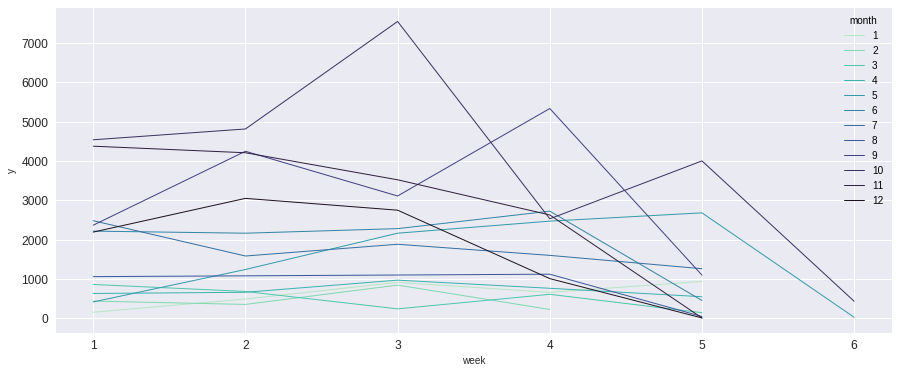

In [ ]:
from math import ceil

# Función que devuelve el día de semana dentro del mes (de 1 a 4)
def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))


por_meses = df[['ds', 'y']].copy()
por_meses['week'] = por_meses.ds.apply(week_of_month)
por_meses['month'] = por_meses.ds.dt.month
por_meses = por_meses.groupby(['month', 'week']).sum().reset_index()

plt.close()
palette = sns.color_palette("mako_r", 12)
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.lineplot(por_meses['week'], por_meses['y'], hue=por_meses['month'], ax=ax, palette=palette)
plt.show()


Si agrupamos los datos semanalmente observamos un ligero patrón mensual. Observamos una ligera estacionalidad mensual. No es muy apreciable ya que el dato que tenemos es diario y diariamente, los patrones mensuales no tienen por qué coincidir. En el  gráfico anterior podemos visualizar como hay cierta tendencia decreciente, de modo que es las primeras semanas del mes y mediados de mes cuando más ventas se producen, decreciendo el número de ventas las últimas semanas de cada mes. Esto se puede deber a que la mayoría de los clientes recibe su salario a primeros de mes. 

In [ ]:
colors = {'red': '#ff207c', 'grey': '#42535b', 'blue': '#207cff', 'orange': '#ffa320', 'green': '#00ec8b'}
config_ticks = {'size': 14, 'color': colors['grey'], 'labelcolor': colors['grey']}
config_title = {'size': 18, 'color': colors['grey'], 'ha': 'left', 'va': 'baseline'}

In [ ]:
def get_charts(stock_data, field):
    plt.rc('figure', figsize=(15, 10))
    
    fig, axes = plt.subplots(2, 1, 
                gridspec_kw={'height_ratios': [3, 1]})
    fig.tight_layout(pad=3)
    
    date = stock_data['ds']
    close = stock_data['y']
    vol = stock_data[field]
    
    plot_price = axes[0]
    plot_price.plot(date, close, color=colors['blue'], 
    linewidth=2, label='Price')
    
    plot_vol = axes[1]
    plot_vol.bar(date, vol, width=15, color='darkgrey')

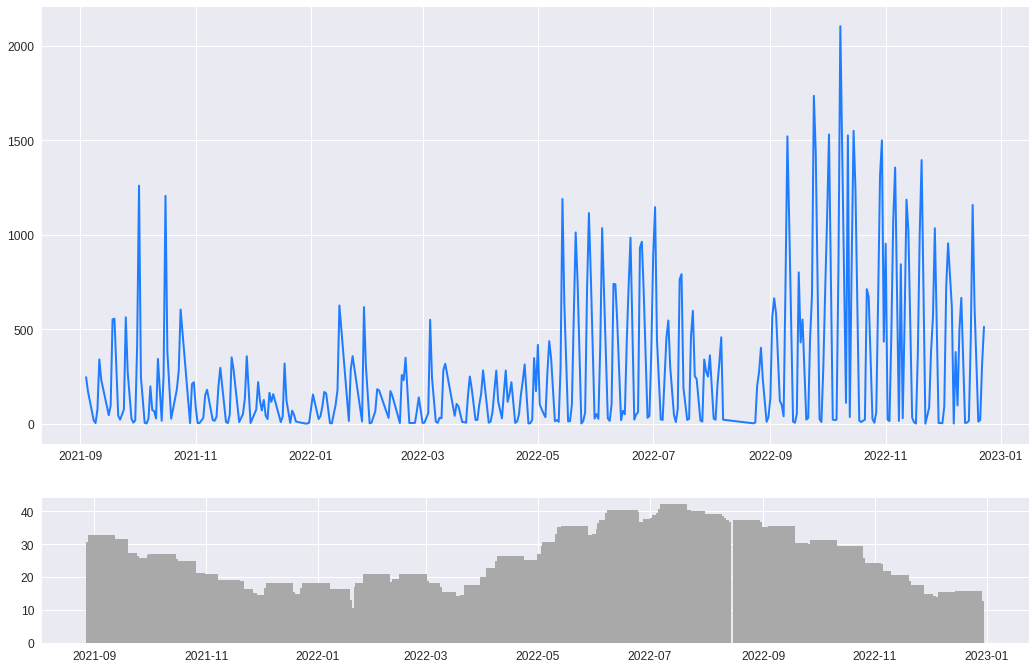

In [ ]:
#Gráfica por días y temperatura
get_charts(df, 'tmax')

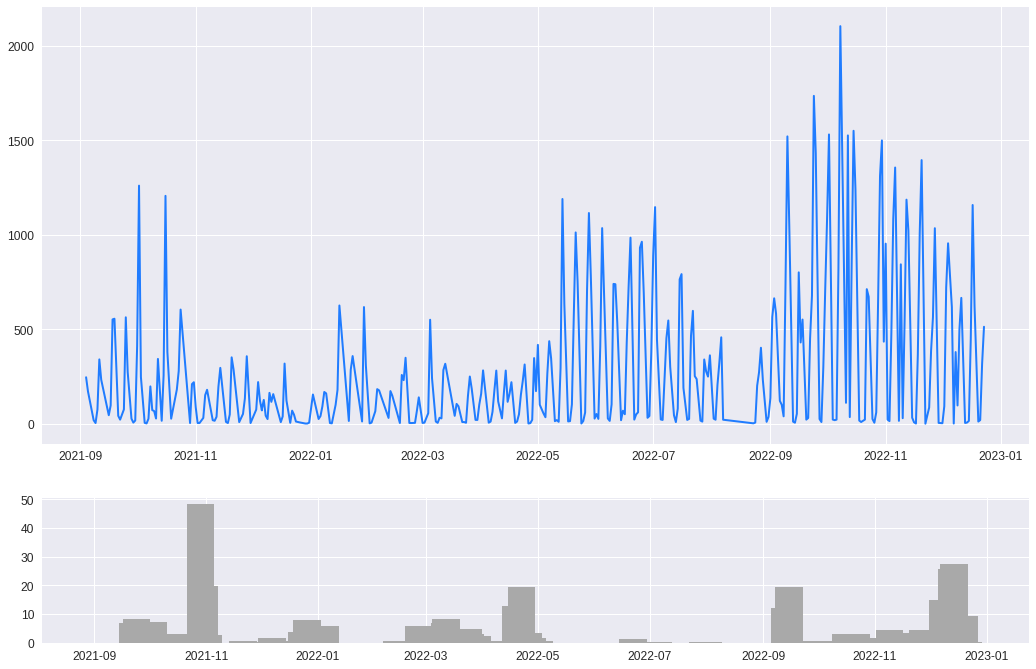

In [ ]:
#Gráfica por días y precipitaciones
get_charts(df, 'prec')

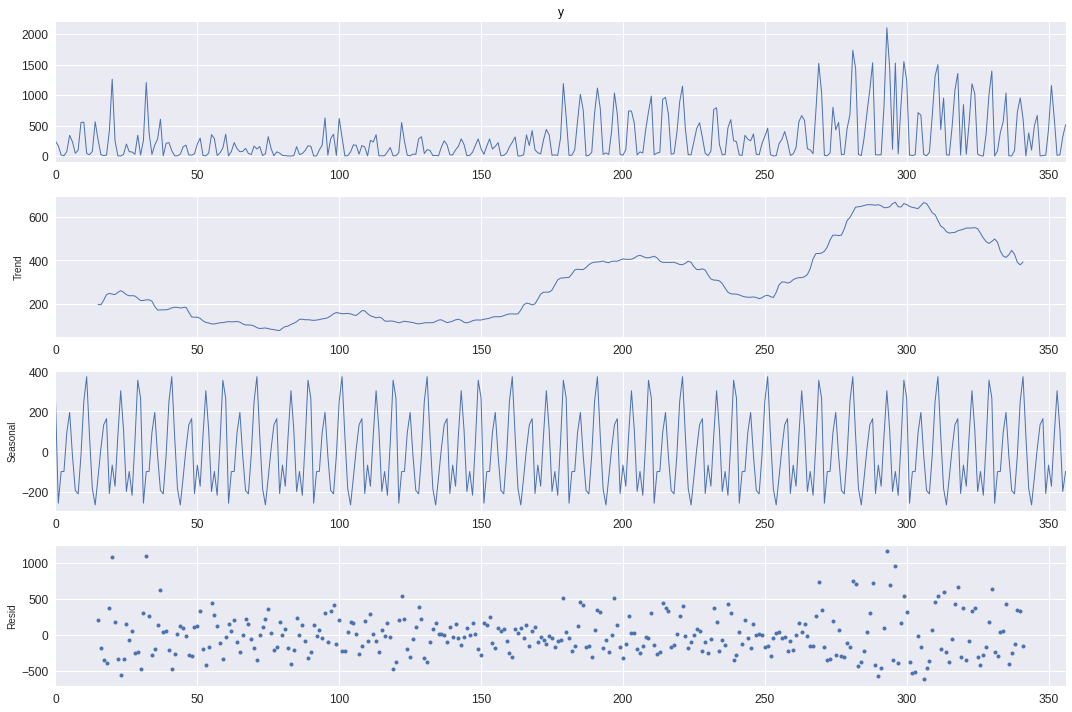

In [ ]:
import statsmodels.api as sm
# Ejemplo de descomposición de serie de tiempo
descomposicion = sm.tsa.seasonal_decompose(df['y'],model='additive', freq=30)  
                                                  
fig = descomposicion.plot()

Conclusiones del análisis
- Se comprueba que no hay registros con datos nulos ni fechas duplicadas
- Los lunes son días en los que no suele haber ventas porque es el día de libranza, por lo tanto son descartados como outlier.
- Existe cierta estacionalidad anual y mensual
- Observamos también una estacionalidad semanal ya que los fines de semana es cuando más ventas se producen.

In [ ]:
#Estacionalidades condicionales

Contiunamos definiendo las estacionalidades semanales encontradas. En el caso de utilizar el método Prophet, se pide definir columnas booleanas complementarias, marcadas a True cuando se cumple la condición y a False cuando no, y otra columna que funcione de manera contraria.

Las condiciones que establecemos son:

-La estacionalidad de los fines de semana (viernes, sábados y domingos)
- El cambio de estacionalidad a partir de mayo de 2022, es decir, que las fechas sean anteriores a esta.

In [ ]:
# Estacionalidades
df['fin_de_semana'] = [True if (dt == 4) or (dt == 5)or (dt == 6) else False for dt in df['dia_semana']]
df['entre_semana'] = [False if (dt == 4) or (dt == 5)or (dt == 6) else True for dt in df['dia_semana']]

df['antes_mayo_2022'] = [True if dt < pd.to_datetime('2022-05-01') else False for dt in df['ds']]
df['despues_mayo_2022'] = [False if dt < pd.to_datetime('2022-05-01') else True for dt in df['ds']]
estacionalidades = ['fin_de_semana', 'entre_semana', 'antes_mayo_2022', 'despues_mayo_2022']


In [ ]:
#recogemos los días festivos
festivos_fechas = df[df['festivo'] == 1].ds
festivos = pd.DataFrame(data = festivos_fechas)
festivos['holiday'] = 'festivo'
festivos.reset_index(drop=True, inplace=True)
festivos

ds  holiday
0 2021-10-12  festivo
1 2021-11-01  festivo
2 2021-12-06  festivo
3 2021-12-08  festivo
4 2022-10-12  festivo
5 2022-11-01  festivo
6 2022-11-09  festivo
7 2022-12-06  festivo
8 2022-12-08  festivo

In [ ]:
#descartamos columnas que no nos aporten más información 
df = df.drop(['dia', 'mes', 'festivo'], axis=1)

Simplificación de regresores

Antes de entrenar los datos, podemos descartar los regresores que aporten poca información. Estos son aquellos que sean constantes o que tengan poca variación:
- media != 0 y coeficiente de variación (std/mean) < 1%variación, es decir que su media sea 0 o su desviación std sea menor de 0.01 
- media != 0 y coeficiente de variación (std/mean) < 1%

- Para el resto, podemos calcular sus correlaciones y ordenar los pares en función de su correlación. Las parejas con una correlación mayor de 0.8, son redundantes, por lo que uno de los componentes de la pareja puede ser eliminado. En esos casos, descartaremos el elemento menos correlacionado con la variable objetivo.

In [ ]:
regresores = [c for c in df.columns if c not in ['ds', 'y'] + estacionalidades]

In [ ]:
# Descarta regresores nulos, constantes o de poca variación
def descartar_constantes(df, regresores, pct_std=0.01, pct_variacion=0.01):
    to_drop = []
    for v in regresores:
        if df[v].mean() == 0:
            if df[v].std() < pct_std:
                print("Media = 0, std < 0.01", v)
                to_drop.append(v)
        elif abs(df[v].std()/df[v].mean()) <= pct_variacion:
            print("Media!= 0, coef_var < 0.2", v, abs(df[v].std()/df[v].mean()))
            to_drop.append(v)
    return df.drop(columns=to_drop)

# Calcula la correlación de cada regresor con la variable objetivo
def calcular_importancias(df, regresores):
    importancias = dict()
    for r in regresores:
        corr = abs(df['y'].corr(df[r]))
        if corr is None:
            corr = 0.0
        importancias[r] = corr
    return importancias

# Descarta uno de cada dos regresores correlacionados entre ellos más de 0.79999.
def descartar_correladas_importancias(df, regresores, corr=0.79999):
    importancias = calcular_importancias(df, regresores)
    list_sorted = regresores.copy()
    list_sorted.sort(key=lambda val: importancias[val], reverse=True)
    dfc = df.reindex(list_sorted, axis=1)
    corr_matrix = dfc.corr().abs()
    corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool)).T
    corr_list = corr_matrix.unstack().reset_index()
    corr_list = corr_list.loc[corr_list[0]>corr]
    to_drop = set()
    for a, b in zip(corr_list['level_0'], corr_list['level_1']):
        if a not in to_drop:
            to_drop.add(b)
    return to_drop

# Simplificación de regresores
df = descartar_constantes(df, regresores)
regresores = [r for r in regresores if r in df.columns]
to_drop = descartar_correladas_importancias(df, regresores)
df.drop(columns=to_drop, inplace=True)
regresores = [r for r in regresores if r not in to_drop]


In [ ]:
to_drop

set()

In [ ]:
regresores

['dia_semana', 'prec', 'tmax']

In [ ]:
#Selección de hiperparámetros

Una vez que tenemos todo lo necesario para entrenar al modelo, lo primero que hacemos es seleccionar los hiperparámetros con Cross Validation sobre el conjunto de entrenamiento (80% de los datos). Cross Validation se basa en medir el error medio del modelo entrenado con cada combinación de parámetros para distinto conjuntos de entrenamiento y test dentro del conjunto de entrenamiento. Los pasos para seleciconar los parámetros son los siguientes:

- Se crea un grid de parámetros con los valores a probar y con ello se obtienen las combinaciones distintas de parámetros posibles.
- Para cada combinación de parámetros, 

Se calcula el error medio para esa combinación haciendo Cross Validation con K iteraciones, en nuestro caso 5. Es decir, se itera 5 veces dividiendo el conjunto de train en un conjunto de train más pequeño que crece en cada iteración un poco, cogiendo como conjunto de test los siguientes 7 días consecutivos al train de esa iteración. En cada iteración se entrena el modelo con esa combinación de parámetros en el subset de train y se guarda su error de predicción en el test.
Se toma la media de errores de test de CV.
Se escoge la combinación de parámetros con menor error medio.
Hay parámetros que vamos a fijar desde el principio, puesto que tenemos suficiente información para tomar una decisión sobre ellos:

- growth: ’linear'
- yearly_seasonality: False (las estacionalidades las vamos a añadir nosotros manualmente)
- weekly_seasonality: False
- daily_seasonality: False
- holidays: festivos (nuestro dataframe de festivos)
- seasonality_mode: ‘multiplicative’ (puesto que se ve en las gráficas que con los años aumenta la dispersión. El efecto estacional es multiplicativo)

Vamos a seleccionar principalmente los prior_scales de los changepoints y de cada una de las estacionalidades.

Prophet permite añadir estacionalidades manualmente con la función add_seasonality, cuyos parámetros son:

- name: nombre de la estacionalidad
- period: periodo de la estacionalidad (por ejemplo 365 para anual)
- fourier_order: orden para la suma de fourier que la aproxima. Valores típicos son:
    - 10 o más para anual, nosotros le damos 11
    - 3 para semanal. En este caso como las estacionalidades semanales son condicionales, jugamos dando un poco más a las fechas en que consideramos que la estacionalidad es más fuerte, y menos en el resto.
- prior_scale: en el caso de la mensual y la anual, las seleccionamos con la selección de hiperparámetros. En el caso de las semanales, damos valores bajos a las estacionalidades de antes y después de septiembre, porque realmente este cambio no afectó tanto a la estacionalidad, y sin embargo damos valores más altos a los prior_scales de navidad o no navidad, para que cargen con la estacionalidad semanal.
- condition_name: nombre de la columna con la condición, para el caso de las estacionalidades condicionales.
Los regresores se añaden con la función add_regressor. Se le pasa el regresor y el modo, que en este caso consideramos que es “additive”.

Funciones principales de un modelo FB Prophet
Las funciones principales, por tanto son:

- m = Prophet(params): esta acción guarda en m el objeto modelo construido con todos los parámetros que se hayan definido.
- m.add_seasonality(…): para añadir estacionalidades manualmente.
- m.add_regressor(…): para añadir otros regresores
- m.fit(df): la función que ajusta m a los datos que haya en df. Requiere como mínimo las columnas ‘ds’ e ‘y’.
- fcst = m.predict(future): predicción hecha sobre las fechas futuras de future. Si se han añadido regresores extra antes del fit con add_regressor, es necesario que future tenga columnas para cada uno de estos regresores y que no haya valores nulos.

In [ ]:
import os
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from pandas import Timestamp

df_train = df.loc[df.index<0.8*df.shape[0]].reset_index(drop=True)

# Valores fijos de las estacionalidades
seasonalities = [{'name': 'yearly', 'period': 365, 'fourier_order':15},
                 {'name': 'antes_mayo_2022', 'period': 7, 'prior_scale':0.05, 
                  'fourier_order':2, 'condition_name': 'antes_mayo_2022'},
                 {'name': 'despues_mayo_2022', 'period': 7, 'prior_scale':1,
                  'fourier_order':4, 'condition_name': 'despues_mayo_2022'},
                 {'name': 'fin_de_semana', 'period': 7, 'prior_scale':4, 
                  'fourier_order':2, 'condition_name': 'fin_de_semana'},
                 {'name': 'entre_semana', 'period': 7, 'prior_scale':4, 
                  'fourier_order':4, 'condition_name': 'entre_semana'},
                 {'name': 'monthly', 'period': 31, 'fourier_order':9},
                 {'name': 'weekly', 'period': 7, 'fourier_order':4}]

param_grid = {'changepoint_prior_scale': [0.002, 0.0025, 0.003],
              'weekly_prior_scale': [0.05, 0.1],
              'monthly_prior_scale': [0.008, 0.009, 0.01], # El efecto de la estacionalidad mensual es bajo
              'yearly_prior_scale': [0.05, 0.1], # El efecto de la estacionalidad anual es más alto
             }


# Generar todas las combinaciones de parámetros a probar
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

cutoffs = ['2022-06-10', '2022-06-24', '2022-07-02', '2022-07-14']
cutoffs = [Timestamp(c) for c in cutoffs]

# Use cross validation to evaluate all parameters
for params in all_params:
    # Añadimos parámetros fijos
    prophet_params = {'growth': 'linear',
                      'changepoints':['2022-06-01'],
                      'yearly_seasonality': False,
                      'weekly_seasonality': False,
                      'daily_seasonality': False,
                      'holidays': festivos,
                      'seasonality_mode': 'multiplicative',
                      'holidays_prior_scale': 700,
                      'changepoint_prior_scale': params['changepoint_prior_scale']}

    m = Prophet(**prophet_params)

    # Añadimos cada una de las estacionalidades
    for s in seasonalities:
        if s['name']=='monthly':
            m.add_seasonality(name=s['name'], period=s['period'], fourier_order=s['fourier_order'],
                              prior_scale=params['monthly_prior_scale'])
            continue
        elif s['name'] == 'yearly':
            m.add_seasonality(name=s['name'], period=s['period'], fourier_order=s['fourier_order'],
                              prior_scale=params['yearly_prior_scale'])
            continue
        elif s['name'] == 'weekly':
            m.add_seasonality(name=s['name'], period=s['period'], fourier_order=s['fourier_order'],
                              prior_scale=params['weekly_prior_scale'])
            continue

        ps = s['prior_scale'] if 'prior_scale' in s else None
        mod = s['mode'] if 'mode' in s else None
        cn = s['condition_name'] if 'condition_name' in s else None
        m.add_seasonality(name=s['name'], period=s['period'],
                          fourier_order=s['fourier_order'],
                          condition_name= cn, prior_scale=ps, mode=mod)

    # Añadimos los regresores
    for r in regresores:
        m.add_regressor(r, mode='additive')

    # Se hace el fit
    m.fit(df_train)

    # En df_cv se guardan los resultados de hacer cross validation con 5 folds
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon="7 days", parallel="processes")
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].values[0])

# Encontramos los mejores parámetros
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses


DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqr26ub9/3pz6sdnw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqr26ub9/qwkns_v2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82867', 'data', 'file=/tmp/tmpiqr26ub9/3pz6sdnw.json', 'init=/tmp/tmpiqr26ub9/qwkns_v2.json', 'output', 'file=/tmp/tmpiqr26ub9/prophet_modelazrhkez3/prophet_model-20230110190529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
19:05:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqr26ub9/4l09efla.

In [ ]:
print('Mejores parámetros')
tuning_results.sort_values(by='rmse').iloc[0]

Mejores parámetros


changepoint_prior_scale      0.003000
weekly_prior_scale           0.050000
monthly_prior_scale          0.008000
yearly_prior_scale           0.050000
rmse                       252.746374
Name: 24, dtype: float64

Los parámetros fijados pueden resultar un tanto aribitrarios. La realidad es que hemos hecho muchas pruebas de ajuste para ver qué funcionaba y qué no..

In [ ]:
#Entrenamiento y predicción

In [ ]:
# Entrenamiento final del modelo
params = {'growth':'linear',
          'changepoints':['2022-06-01'],
          'yearly_seasonality': False,
          'weekly_seasonality': False,
          'daily_seasonality': False,
          'holidays': festivos,
          'seasonality_mode': 'multiplicative',
          'holidays_prior_scale': 700,
          'changepoint_prior_scale': tuning_results.sort_values(by='rmse').iloc[0]['changepoint_prior_scale'],
          'interval_width': 0.80,
          'uncertainty_samples': 100}


seasonalities = [{'name': 'yearly', 'period': 365, 'fourier_order':15,
                  'prior_scale':tuning_results.sort_values(by='rmse').iloc[0]['yearly_prior_scale']},
                 {'name': 'antes_mayo_2022', 'period': 7, 'prior_scale':0.05, 
                  'fourier_order':2, 'condition_name': 'antes_mayo_2022'},
                 {'name': 'despues_mayo_2022', 'period': 7, 'prior_scale':1,
                  'fourier_order':4, 'condition_name': 'despues_mayo_2022'},
                 {'name': 'fin_de_semana', 'period': 7, 'prior_scale':4, 
                  'fourier_order':2, 'condition_name': 'fin_de_semana'},
                 {'name': 'entre_semana', 'period': 7, 'prior_scale':4, 
                  'fourier_order':4, 'condition_name': 'entre_semana'},
                 {'name': 'weekly', 'period': 7, 'fourier_order':4,
                 'prior_scale':tuning_results.sort_values(by='rmse').iloc[0]['weekly_prior_scale']},
                 {'name': 'monthly', 'period': 31, 'fourier_order':9,
                  'prior_scale':tuning_results.sort_values(by='rmse').iloc[0]['monthly_prior_scale']}]


end_train= df.loc[df.index<0.8*df.shape[0], 'ds'].max()

m = Prophet(**params)
for s in seasonalities:
    m.add_seasonality(**s)

for r in regresores:
    m.add_regressor(r, mode='additive')

df_train = df.loc[df['ds'] < end_train]
df_test = df.loc[~(df['ds'] < end_train)]

m.fit(df_train)
forecast_test = m.predict(df_test)
forecast_train = m.predict(df_train)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqr26ub9/40a_3pu7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiqr26ub9/rmlq4k0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92998', 'data', 'file=/tmp/tmpiqr26ub9/40a_3pu7.json', 'init=/tmp/tmpiqr26ub9/rmlq4k0g.json', 'output', 'file=/tmp/tmpiqr26ub9/prophet_modelbdhkj32m/prophet_model-20230110191826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


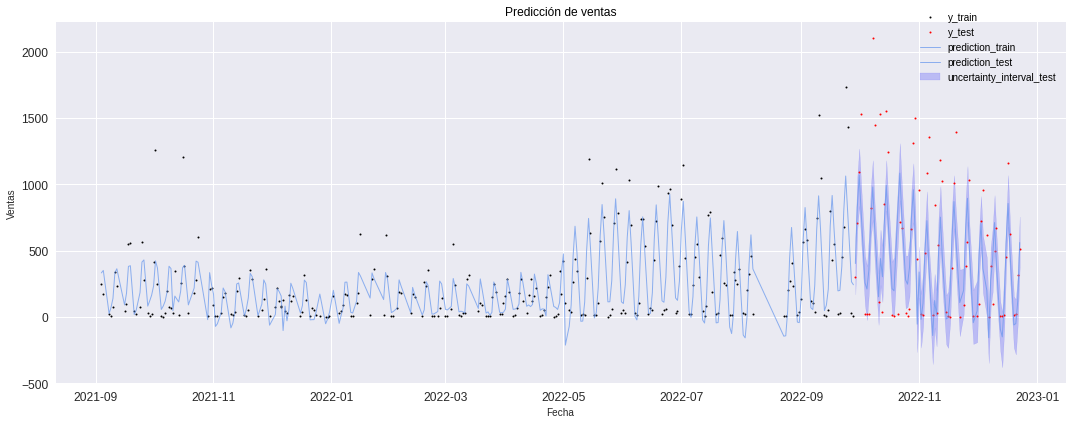

In [ ]:
# Gráfica de la predicción
plt.close()
legend = ['y_train', 'y_test', 'prediction_train', 'prediction_test']

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(df_train['ds'], df_train['y'], c='black', marker='o', markersize=2, ls='')
ax.plot(df_test['ds'], df_test['y'], c='r', marker='o', markersize=2, ls='')
ax.plot(forecast_train['ds'], forecast_train['yhat'], ls='-', color='cornflowerblue', alpha=0.7)
ax.plot(forecast_test['ds'], forecast_test['yhat'], ls='-', color='cornflowerblue', alpha=0.7)
ax.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='b', alpha=0.2)
legend.append('uncertainty_interval_test')
ax.legend(legend, bbox_to_anchor=(1.0, 1.05))
ax.set(title='Predicción de ventas', xlabel='Fecha', ylabel='Ventas')
plt.tight_layout()
plt.show()

Medición del error

- Podemos Utilizar MAPE para medir el error sobre el periodo de test. No se ha utilizado durante el Cross Validation debido a que Prophet no calcula esta métrica en su función cross_validation además de por simplificar el proceso. Un punto a favor de la métrica MAPE, es que da una medición del error relativo, en porcentaje respecto al dato real, y por ello su interpretación es más intuitiva que la de la métrica MSE, siendo el valor de este la distacia cuadrada media entre la precicción y el dato real. Un Mape con buenos resultados estaría por debajo del 20%. También podemos medir como se ajusta de bine nuestro modelo a la variabilidad de los datos con la métrica R^2. Tomando valores entre 0%-100%, un buen modelo debería estar entorno al 70%.

In [ ]:
from sklearn.metrics import r2_score

def MAPE(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean([100*abs((actual[i]-forecast[i])/actual[i]) for i in range(len(actual))])

def metrics(df_train, forecast_train, df_test, forecast_test):
    MAPE_metric = pd.DataFrame(index=['MAPE'],
                               data={'Train': [MAPE(df_train['y'], forecast_train['yhat'])],
                                    'Test': [MAPE(df_test['y'], forecast_test['yhat'])]})
    r2_metric = pd.DataFrame(index=['R2'],
                             data={'Train': [100*r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])],
                                   'Test': [100*r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])]})

    return pd.concat([MAPE_metric, r2_metric])


In [ ]:
metrics(df_train, forecast_train, df_test, forecast_test)

Train        Test
MAPE  274.812707  655.781645
R2     69.691210   43.526077